Rossman Sales Prediction

In [31]:
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce

import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import pickle

Data Loading:

In [32]:
df_store = pd.read_csv("C:\\Users\\ADMIN\\Downloads\\Rossman\\store.csv")
df_train = pd.read_csv("C:\\Users\\ADMIN\\Downloads\\Rossman\\train.csv")

Data Preprocessing:

In [33]:
df_store["CompetitionDistance"].fillna(value = df_store.CompetitionDistance.median(), inplace=True)

In [34]:
df_store["CompetitionOpenSinceMonth"].fillna(value = df_store.CompetitionOpenSinceMonth.mode()[0], inplace=True)
df_store["CompetitionOpenSinceYear"].fillna(value = df_store.CompetitionOpenSinceYear.mode()[0], inplace=True)

In [35]:
df_store["Promo2SinceWeek"].fillna(value = 0, inplace=True)
df_store["Promo2SinceYear"].fillna(value = 0, inplace=True)
df_store["PromoInterval"].fillna(value = 0, inplace=True)

In [36]:
df_rossmann = pd.read_csv("merged.csv")

In [37]:
df_rossmann['Date'] = pd.to_datetime(df_rossmann['Date'])
df_rossmann["StateHoliday"].replace({'0':0, 'a':1, 'b':1, 'c':1}, inplace=True)
df_rossmann = df_rossmann.astype({"CompetitionOpenSinceMonth":int, "CompetitionOpenSinceYear":int, "Promo2SinceWeek":int, "Promo2SinceYear":int})





In [38]:
get_week_number = lambda x: x.isocalendar()[1]
df_rossmann['WeekOfYear'] = df_rossmann['Date'].apply(get_week_number)
df_rossmann['Month'] = df_rossmann['Date'].dt.month
df_rossmann['Year'] = df_rossmann['Date'].dt.year

In [39]:
df_rossmann['CompetitionOpenNumMonths'] = (df_rossmann['Year'] - df_rossmann['CompetitionOpenSinceYear']) * 12 + (df_rossmann['Month'] - df_rossmann['CompetitionOpenSinceMonth'])

In [40]:

df_rossmann['Promo2NumWeeks'] = (df_rossmann['Year'] - df_rossmann['Promo2SinceYear']) * 52 + (df_rossmann['WeekOfYear'] - df_rossmann['Promo2SinceWeek'])
df_rossmann.loc[df_rossmann['Promo2'] == 0, 'Promo2NumWeeks'] = 0
df_rossmann['CompetitionOpenNumMonths'] = df_rossmann['CompetitionOpenNumMonths'].apply(lambda x: 0 if x < 0 else x)
df_rossmann['Promo2NumWeeks'] = df_rossmann['Promo2NumWeeks'].apply(lambda x: 0 if x < 0 else x)

df_rossmann.drop('Store', axis=1, inplace=True)
df_rossmann.drop('Date', axis=1, inplace=True)
df_rossmann.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)
df_rossmann.drop(['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'], axis=1, inplace=True)
df_rossmann.drop('Month', axis=1, inplace=True)
df_rossmann.drop('Year', axis=1, inplace= True)
df_rossmann.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,WeekOfYear,CompetitionOpenNumMonths,Promo2NumWeeks
0,5,5263,555,1,1,0,1,c,a,1270.0,0,31,82,0
1,5,6064,625,1,1,0,1,a,a,570.0,"Jan,Apr,Jul,Oct",31,92,278
2,5,8314,821,1,1,0,1,a,a,14130.0,"Jan,Apr,Jul,Oct",31,103,225
3,5,13995,1498,1,1,0,1,c,c,620.0,0,31,70,0
4,5,4822,559,1,1,0,1,a,a,29910.0,0,31,3,0


In [41]:
def remove_outliers_iqr(df, condition, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_filter = df[condition & ((df[column] < lower_bound) | (df[column] > upper_bound))].index
    df.drop(outlier_filter, inplace=True)


In [42]:

remove_outliers_iqr(df_rossmann, (df_rossmann['StoreType'] == 'a'), 'Sales')
remove_outliers_iqr(df_rossmann, (df_rossmann['StoreType'] == 'a'), 'Customers')
remove_outliers_iqr(df_rossmann, (df_rossmann['StoreType'] == 'd'), 'Sales')
remove_outliers_iqr(df_rossmann, (df_rossmann['StoreType'] == 'd'), 'Customers')
remove_outliers_iqr(df_rossmann, (df_rossmann['Assortment'] == 'a'), 'Sales')
remove_outliers_iqr(df_rossmann, (df_rossmann['Assortment'] == 'a'), 'Customers')

"""
a_filter = df_rossmann[(df_rossmann['StoreType'] == 'a') & (((df_rossmann['Sales'] > 20000) & (df_rossmann['Customers'] < 1000)) | 
                                                            (df_rossmann['Sales'] > 40000) | (df_rossmann['Customers'] > 7000))].index
c_filter = df_rossmann[(df_rossmann['StoreType'] == 'c') & (((df_rossmann['Sales'] > 9000) & (df_rossmann['Customers'] < 500)) |
                                                            ((df_rossmann['Sales'] < 15000) & (df_rossmann['Customers'] > 2500)) |
                                                            ((df_rossmann['Sales'] > 25000) & (df_rossmann['Customers'] < 2000)) |
                                                             (df_rossmann['Sales'] > 30000))].index
d_filter = df_rossmann[(df_rossmann['StoreType'] == 'd') & ((df_rossmann['Sales'] > 17500) & (df_rossmann['Customers'] < 875) |
                                                            (df_rossmann['Sales'] > 31000) | (df_rossmann['Customers'] > 2000))].index

df_rossmann.drop(a_filter, inplace=True)
df_rossmann.drop(c_filter, inplace=True)
df_rossmann.drop(d_filter, inplace=True)
a_filter = df_rossmann[(df_rossmann['Assortment'] == 'a') & (((df_rossmann['Sales'] > 20000) & (df_rossmann['Customers'] < 1000)) |
                                                             ((df_rossmann['Sales'] > 27500) & (df_rossmann['Customers'] < 2000)) |
                                                             ((df_rossmann['Sales'] > 31000) & (df_rossmann['Customers'] < 3250)) |
                                                              (df_rossmann['Sales'] > 35000))].index
df_rossmann.drop(a_filter, inplace=True)
"""

"\na_filter = df_rossmann[(df_rossmann['StoreType'] == 'a') & (((df_rossmann['Sales'] > 20000) & (df_rossmann['Customers'] < 1000)) | \n                                                            (df_rossmann['Sales'] > 40000) | (df_rossmann['Customers'] > 7000))].index\nc_filter = df_rossmann[(df_rossmann['StoreType'] == 'c') & (((df_rossmann['Sales'] > 9000) & (df_rossmann['Customers'] < 500)) |\n                                                            ((df_rossmann['Sales'] < 15000) & (df_rossmann['Customers'] > 2500)) |\n                                                            ((df_rossmann['Sales'] > 25000) & (df_rossmann['Customers'] < 2000)) |\n                                                             (df_rossmann['Sales'] > 30000))].index\nd_filter = df_rossmann[(df_rossmann['StoreType'] == 'd') & ((df_rossmann['Sales'] > 17500) & (df_rossmann['Customers'] < 875) |\n                                                            (df_rossmann['Sales'] > 31000) | (df_rossman

In [43]:
#df_rossmann.drop(df_rossmann[df_rossmann['CompetitionDistance'] > 37500].index, inplace=True)
remove_outliers_iqr(df_rossmann, True, 'CompetitionDistance')

In [44]:
df_rossmann['Sales'] = np.sqrt(df_rossmann['Sales'])
df_rossmann['Customers'] = np.sqrt(df_rossmann['Customers'])
df_rossmann['CompetitionOpenNumMonths'] = np.sqrt(df_rossmann['CompetitionOpenNumMonths'])
df_rossmann['Promo2NumWeeks'] = np.sqrt(df_rossmann['Promo2NumWeeks'])

df_rossmann['CompetitionDistance'] = np.log(df_rossmann['CompetitionDistance'])

In [45]:
bin = ce.BinaryEncoder(cols=['DayOfWeek']).fit_transform(df_rossmann['DayOfWeek'])
df_rossmann = pd.concat([df_rossmann, bin], axis=1)
df_rossmann.drop('DayOfWeek', axis=1, inplace=True)

bin = ce.BinaryEncoder(cols=['WeekOfYear']).fit_transform(df_rossmann['WeekOfYear'])
df_rossmann = pd.concat([df_rossmann, bin], axis=1)
df_rossmann.drop('WeekOfYear', axis=1, inplace=True)

In [46]:
cat_col = ['StoreType', 'Assortment']
data_cat = df_rossmann[cat_col].copy()

data_cat = pd.get_dummies(data_cat,columns=cat_col)
data_cat = data_cat.astype(int)

df_rossmann = pd.concat([df_rossmann, data_cat],axis=1)
df_rossmann.drop(columns=cat_col,inplace=True)


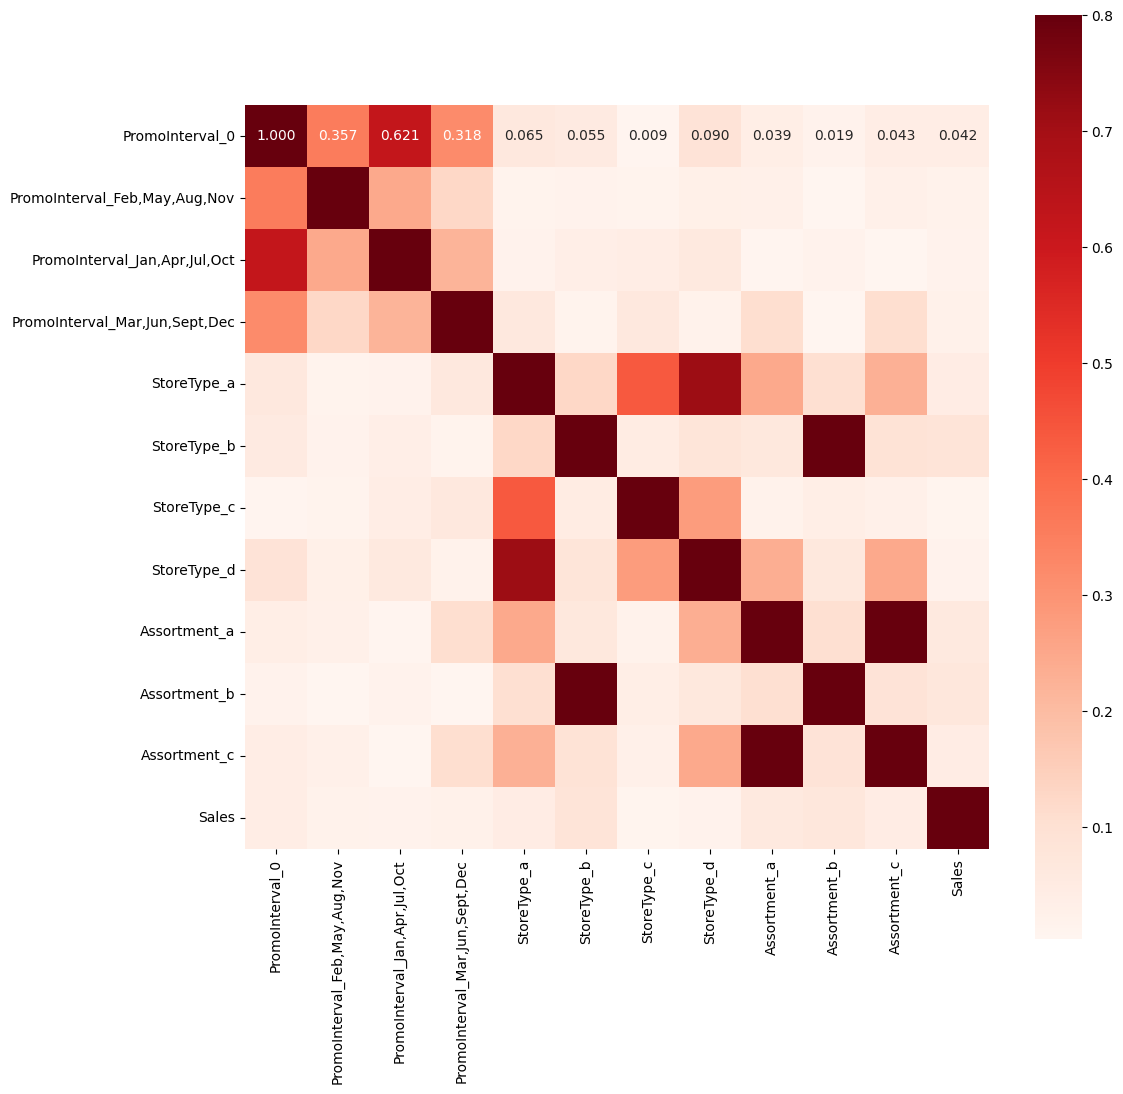

In [47]:
df_rossmann = pd.get_dummies(df_rossmann, columns=['PromoInterval'])

corr_mat = df_rossmann.loc[:, ['PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec', 
                               'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Sales']].corr().abs()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.3f', annot_kws={'size': 10},  vmax=.8, square=True, cmap="Reds")
df_rossmann.drop(['PromoInterval_Jan,Apr,Jul,Oct', 'StoreType_c', 'Assortment_b'], axis=1, inplace=True)

In [48]:
def calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred):
  metrics_dict = {}

  metrics_dict['Train_R2'] = r2_score(y_train, y_train_pred)
  metrics_dict['Test_R2'] = r2_score(y_test, y_test_pred)
  metrics_dict['Train_RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
  metrics_dict['Test_RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
  metrics_dict['Train_RMSPE'] = calculate_rmspe(y_train, y_train_pred)
  metrics_dict['Test_RMSPE'] = calculate_rmspe(y_test, y_test_pred)

  return metrics_dict
def calculate_rmspe(y_actual, y_pred):
  return (np.sqrt(np.mean(np.square(y_actual.to_numpy() - y_pred))) / np.mean(y_actual.to_numpy())) * 100
column_names = df_rossmann.columns.tolist()
column_names

['Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpenNumMonths',
 'Promo2NumWeeks',
 'DayOfWeek_0',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'WeekOfYear_0',
 'WeekOfYear_1',
 'WeekOfYear_2',
 'WeekOfYear_3',
 'WeekOfYear_4',
 'WeekOfYear_5',
 'StoreType_a',
 'StoreType_b',
 'StoreType_d',
 'Assortment_a',
 'Assortment_c',
 'PromoInterval_0',
 'PromoInterval_Feb,May,Aug,Nov',
 'PromoInterval_Mar,Jun,Sept,Dec']

In [49]:
X = df_rossmann.drop(['Sales', 'Customers', 'Promo'], axis=1)
y = df_rossmann['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [50]:
metrics_table = pd.DataFrame(columns=['Regression_Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_RMSPE', 'Test_RMSPE'])

In [51]:
linear_reg = LinearRegression()
liner_reg_model = Pipeline([('scaler', StandardScaler()), ('linear_reg', linear_reg)])
liner_reg_model.fit(X_train, y_train)
y_train_pred = liner_reg_model.predict(X_train)
y_test_pred = liner_reg_model.predict(X_test)


In [52]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = ['Linear', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]



Testing Data
R2    : 0.8476642707995622
RMSE  : 12.999498560387794
RMSPE : 19.888679725994457%


In [53]:
ridge_regression = Ridge()
ridge_regression_model = Pipeline([('scaler', StandardScaler()), ( 'ridge', ridge_regression)])
ridge_regression_model.fit(X_train, y_train)
y_train_pred = ridge_regression_model.predict(X_train)
y_test_pred = ridge_regression_model.predict(X_test)

In [54]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = ['Decision_Tree', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]



Testing Data
R2    : 0.8476642763078039
RMSE  : 12.999498325366172
RMSPE : 19.888679366421375%


In [55]:
lasso_regression = Lasso()
lasso_regression_model = Pipeline([('scaler', StandardScaler()), ( 'lasso', lasso_regression )])
lasso_regression_model.fit(X_train, y_train)
y_train_pred = lasso_regression_model.predict(X_train)
y_test_pred = lasso_regression_model.predict(X_test)

In [56]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = ['Decision_Tree', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]


Testing Data
R2    : 0.841542937701962
RMSE  : 13.258106777944029
RMSPE : 20.28433929621505%


In [57]:
knn = KNeighborsRegressor(n_neighbors = 1,weights = 'uniform')
knn_model = Pipeline([('scaler', StandardScaler()), ('k-neighbor', knn)])
knn_model.fit(X_train,y_train)
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

In [58]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = ['K-Neighbor', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]


Testing Data
R2    : 0.8091050711762889
RMSE  : 14.55200743870878
RMSPE : 22.26395225741184%


In [59]:
random_forest = RandomForestRegressor()
random_forest_model = Pipeline([('scaler', StandardScaler()), ('random_forest', random_forest)])
random_forest_model.fit(X_train, y_train)
y_train_pred = random_forest_model.predict(X_train)
y_test_pred = random_forest_model.predict(X_test)

In [60]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = ['Random_Forest', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]



Testing Data
R2    : 0.9615290964551854
RMSE  : 6.532687830514726
RMSPE : 9.99473444359788%


In [65]:
xgboost = xgb.XGBRegressor()
xgboost_model = Pipeline([('scaler', StandardScaler()), ('xgboost', xgboost)])
xgboost_model.fit(X_train, y_train)
y_train_pred = xgboost_model.predict(X_train)
y_test_pred = xgboost_model.predict(X_test)

In [66]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = ['XG_Boost', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]


Testing Data
R2    : 0.9467950719088336
RMSE  : 7.682483614356108
RMSPE : 11.753873074129627%


Improve with Hyperparameter

In [68]:
random_forest = RandomForestRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}


rf_reg = GridSearchCV(estimator=random_forest, param_grid=parameters, cv=3)
rf_reg.fit(X_train, y_train)

print("The best parameters for random forest regression: ")
for key, value in rf_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {rf_reg.best_score_}")

# predict the train and test data
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'n_iter'

In [ ]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8536533266383369
RMSE  : 12.751160876935884
RMSPE : 19.494519011395766%

Testing Data
R2    : 0.854223773436846
RMSE  : 12.716543010507914
RMSPE : 19.455769773190422%


In [ ]:
# train data with XGBoost regression
xgboost = xgb.XGBRegressor(objective='reg:linear', verbosity=0)
parameters = {'max_depth': [2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

# RandomizedSearchCV is used for hyperparameter tuning because XGBRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
xg_reg = RandomizedSearchCV(estimator=xgboost, param_distributions=parameters, n_iter=10, cv=3)
xg_reg.fit(X_train, y_train)

print("The best parameters for XGBoost regression: ")
for key, value in xg_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {xg_reg.best_score_}")


y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)

In [ ]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

metrics_table.loc[len(metrics_table.index)] = ['XGBoost',  model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]